<font color='blue' size="+3">Explainable Machine Learning Model for Lung Cancer prediction with improved accuracy</font>


In [3]:
#!pip install catboost
#!pip install lime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import missingno as msno
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    cohen_kappa_score, f1_score, roc_curve, roc_auc_score, auc,
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, balanced_accuracy_score, precision_score,
    recall_score
)
from sklearn.ensemble import (
    RandomForestClassifier, BaggingClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, ExtraTreesClassifier
)
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from tqdm import tqdm

import lime
from lime.lime_tabular import LimeTabularExplainer
from lime import lime_tabular


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold



In [4]:
#   first read the data file
df= pd.read_csv('lung_clean.csv')

# Exploratory Data Analysis

We need to explore/clean/filter it before processing it for machine learning It involves adding/deleting few columns or rows, joining some other data, and handling qualitative variables like dates.

In [5]:
df.shape

(276, 16)

In [6]:
df.head()

GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
0       1   69        1               0        0              1   
1       1   74        0               1        1              1   
2       0   59        1               1        1              0   
3       1   63        0               0        0              1   
4       0   63        1               0        1              1   

   CHRONIC.DISEASE  FATIGUE  ALLERGY  WHEEZING  ALCOHOL.CONSUMING  COUGHING  \
0                1        0        1         0                  0         0   
1                0        0        0         1                  1         1   
2                1        0        1         0                  1         0   
3                1        1        1         1                  0         1   
4                1        1        1         0                  1         0   

   SHORTNESS.OF.BREATH  SWALLOWING.DIFFICULTY  CHEST.PAIN  LUNG_CANCER  
0                    0                      0           0            1  
1                    0                      0           0            1  
2                    0                      1           0            0  
3                    1                      0           0            0  
4                    0                      1           1            0

In [7]:
df.describe()

GENDER         AGE     SMOKING  YELLOW_FINGERS     ANXIETY  \
count  276.000000  276.000000  276.000000      276.000000  276.000000   
mean     0.514493   62.909420    0.456522        0.423913    0.503623   
std      0.500698    8.379355    0.499011        0.495075    0.500895   
min      0.000000   21.000000    0.000000        0.000000    0.000000   
25%      0.000000   57.750000    0.000000        0.000000    0.000000   
50%      1.000000   62.500000    0.000000        0.000000    1.000000   
75%      1.000000   69.000000    1.000000        1.000000    1.000000   
max      1.000000   87.000000    1.000000        1.000000    1.000000   

       PEER_PRESSURE  CHRONIC.DISEASE     FATIGUE     ALLERGY    WHEEZING  \
count     276.000000       276.000000  276.000000  276.000000  276.000000   
mean        0.492754         0.478261    0.336957    0.452899    0.452899   
std         0.500856         0.500435    0.473529    0.498681    0.498681   
min         0.000000         0.000000    0.000000    0.000000    0.000000   
25%         0.000000         0.000000    0.000000    0.000000    0.000000   
50%         0.000000         0.000000    0.000000    0.000000    0.000000   
75%         1.000000         1.000000    1.000000    1.000000    1.000000   
max         1.000000         1.000000    1.000000    1.000000    1.000000   

       ALCOHOL.CONSUMING    COUGHING  SHORTNESS.OF.BREATH  \
count         276.000000  276.000000           276.000000   
mean            0.449275    0.423913             0.369565   
std             0.498324    0.495075             0.483564   
min             0.000000    0.000000             0.000000   
25%             0.000000    0.000000             0.000000   
50%             0.000000    0.000000             0.000000   
75%             1.000000    1.000000             1.000000   
max             1.000000    1.000000             1.000000   

       SWALLOWING.DIFFICULTY  CHEST.PAIN  LUNG_CANCER  
count             276.000000  276.000000   276.000000  
mean                0.532609    0.442029     0.862319  
std                 0.499842    0.497530     0.345191  
min                 0.000000    0.000000     0.000000  
25%                 0.000000    0.000000     1.000000  
50%                 1.000000    0.000000     1.000000  
75%                 1.000000    1.000000     1.000000  
max                 1.000000    1.000000     1.000000

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   GENDER                 276 non-null    int64
 1   AGE                    276 non-null    int64
 2   SMOKING                276 non-null    int64
 3   YELLOW_FINGERS         276 non-null    int64
 4   ANXIETY                276 non-null    int64
 5   PEER_PRESSURE          276 non-null    int64
 6   CHRONIC.DISEASE        276 non-null    int64
 7   FATIGUE                276 non-null    int64
 8   ALLERGY                276 non-null    int64
 9   WHEEZING               276 non-null    int64
 10  ALCOHOL.CONSUMING      276 non-null    int64
 11  COUGHING               276 non-null    int64
 12  SHORTNESS.OF.BREATH    276 non-null    int64
 13  SWALLOWING.DIFFICULTY  276 non-null    int64
 14  CHEST.PAIN             276 non-null    int64
 15  LUNG_CANCER            276 non-null    i

In [9]:
df.columns

Index(['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY',
       'PEER_PRESSURE', 'CHRONIC.DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING',
       'ALCOHOL.CONSUMING', 'COUGHING', 'SHORTNESS.OF.BREATH',
       'SWALLOWING.DIFFICULTY', 'CHEST.PAIN', 'LUNG_CANCER'],
      dtype='object')

In [10]:
df.isnull().sum()

GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC.DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL.CONSUMING        0
COUGHING                 0
SHORTNESS.OF.BREATH      0
SWALLOWING.DIFFICULTY    0
CHEST.PAIN               0
LUNG_CANCER              0
dtype: int64

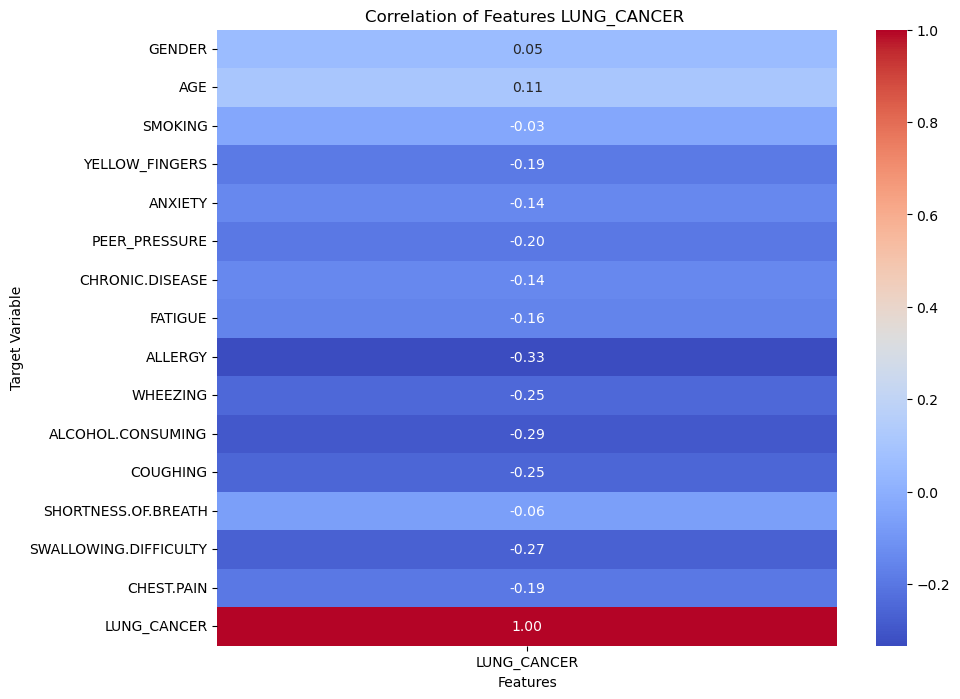

In [11]:



# Compute Pearson correlation coefficients
corr_matrix = df.corr()

# Extract correlations of features with the target variable
target_corr = corr_matrix['LUNG_CANCER']

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation of Features LUNG_CANCER ')
plt.xlabel('Features')
plt.ylabel('Target Variable')
plt.show()


#Feature Selection

In [12]:
X = df.drop(columns=['LUNG_CANCER'])  # Features
y = df['LUNG_CANCER']  # Target variable

# Calculate the correlation coefficients between features and the target variable
correlation_scores = X.corrwith(y)

# Select features with correlation coefficient above a threshold (e.g., 0.01)
selected_features = correlation_scores[abs(correlation_scores) > 0.01].index.tolist()
# Include the target variable in the selected features
selected_features.append('LUNG_CANCER')

# Create a new DataFrame with selected features and target variable
df_selected = df[selected_features]
# Print the selected features
print("Selected features:", selected_features)


Selected features: ['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE', 'CHRONIC.DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING', 'ALCOHOL.CONSUMING', 'COUGHING', 'SHORTNESS.OF.BREATH', 'SWALLOWING.DIFFICULTY', 'CHEST.PAIN', 'LUNG_CANCER']


In [13]:
df_copy = df_selected.copy()

In [14]:
correlation_scores

GENDER                   0.053666
AGE                      0.106305
SMOKING                 -0.034878
YELLOW_FINGERS          -0.189192
ANXIETY                 -0.144322
PEER_PRESSURE           -0.195086
CHRONIC.DISEASE         -0.143692
FATIGUE                 -0.160078
ALLERGY                 -0.333552
WHEEZING                -0.249054
ALCOHOL.CONSUMING       -0.294422
COUGHING                -0.253027
SHORTNESS.OF.BREATH     -0.064407
SWALLOWING.DIFFICULTY   -0.268940
CHEST.PAIN              -0.194856
dtype: float64

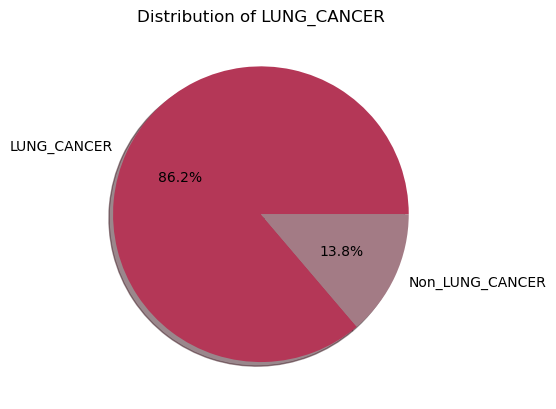

In [15]:
# Create a pie chart of the distribution of Malaria result

# Define labels and colors
custom_colors = ['#B43757', '#a37b85']
labels = ['LUNG_CANCER', 'Non_LUNG_CANCER']

#get the counts
result_counts = df_copy['LUNG_CANCER'].value_counts()

# Create pie chart
plt.pie(result_counts, labels=labels, autopct='%1.1f%%', colors=custom_colors, shadow=True)
plt.title('Distribution of LUNG_CANCER')
plt.show()


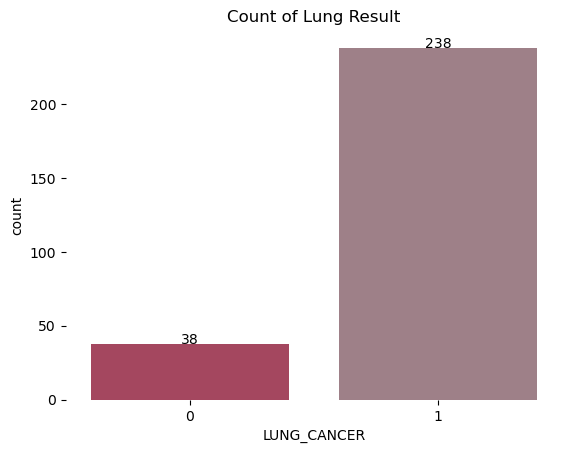

In [16]:
# Create a count plot of the Malaria result

ax = sns.countplot(x='LUNG_CANCER', data=df_copy, palette=custom_colors)
plt.title('Count of Lung Result')

# Add labels to the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.1, '{:.0f}'.format(height), ha='center')

# Remove spines
sns.despine(left=True, bottom=True)

plt.show()


 We need to address the class imbalance in our data before building a predictive model

Imbalanced classes can cause issues in machine learning models, as the model may be biased towards the majority class and may not perform well on the minority class.

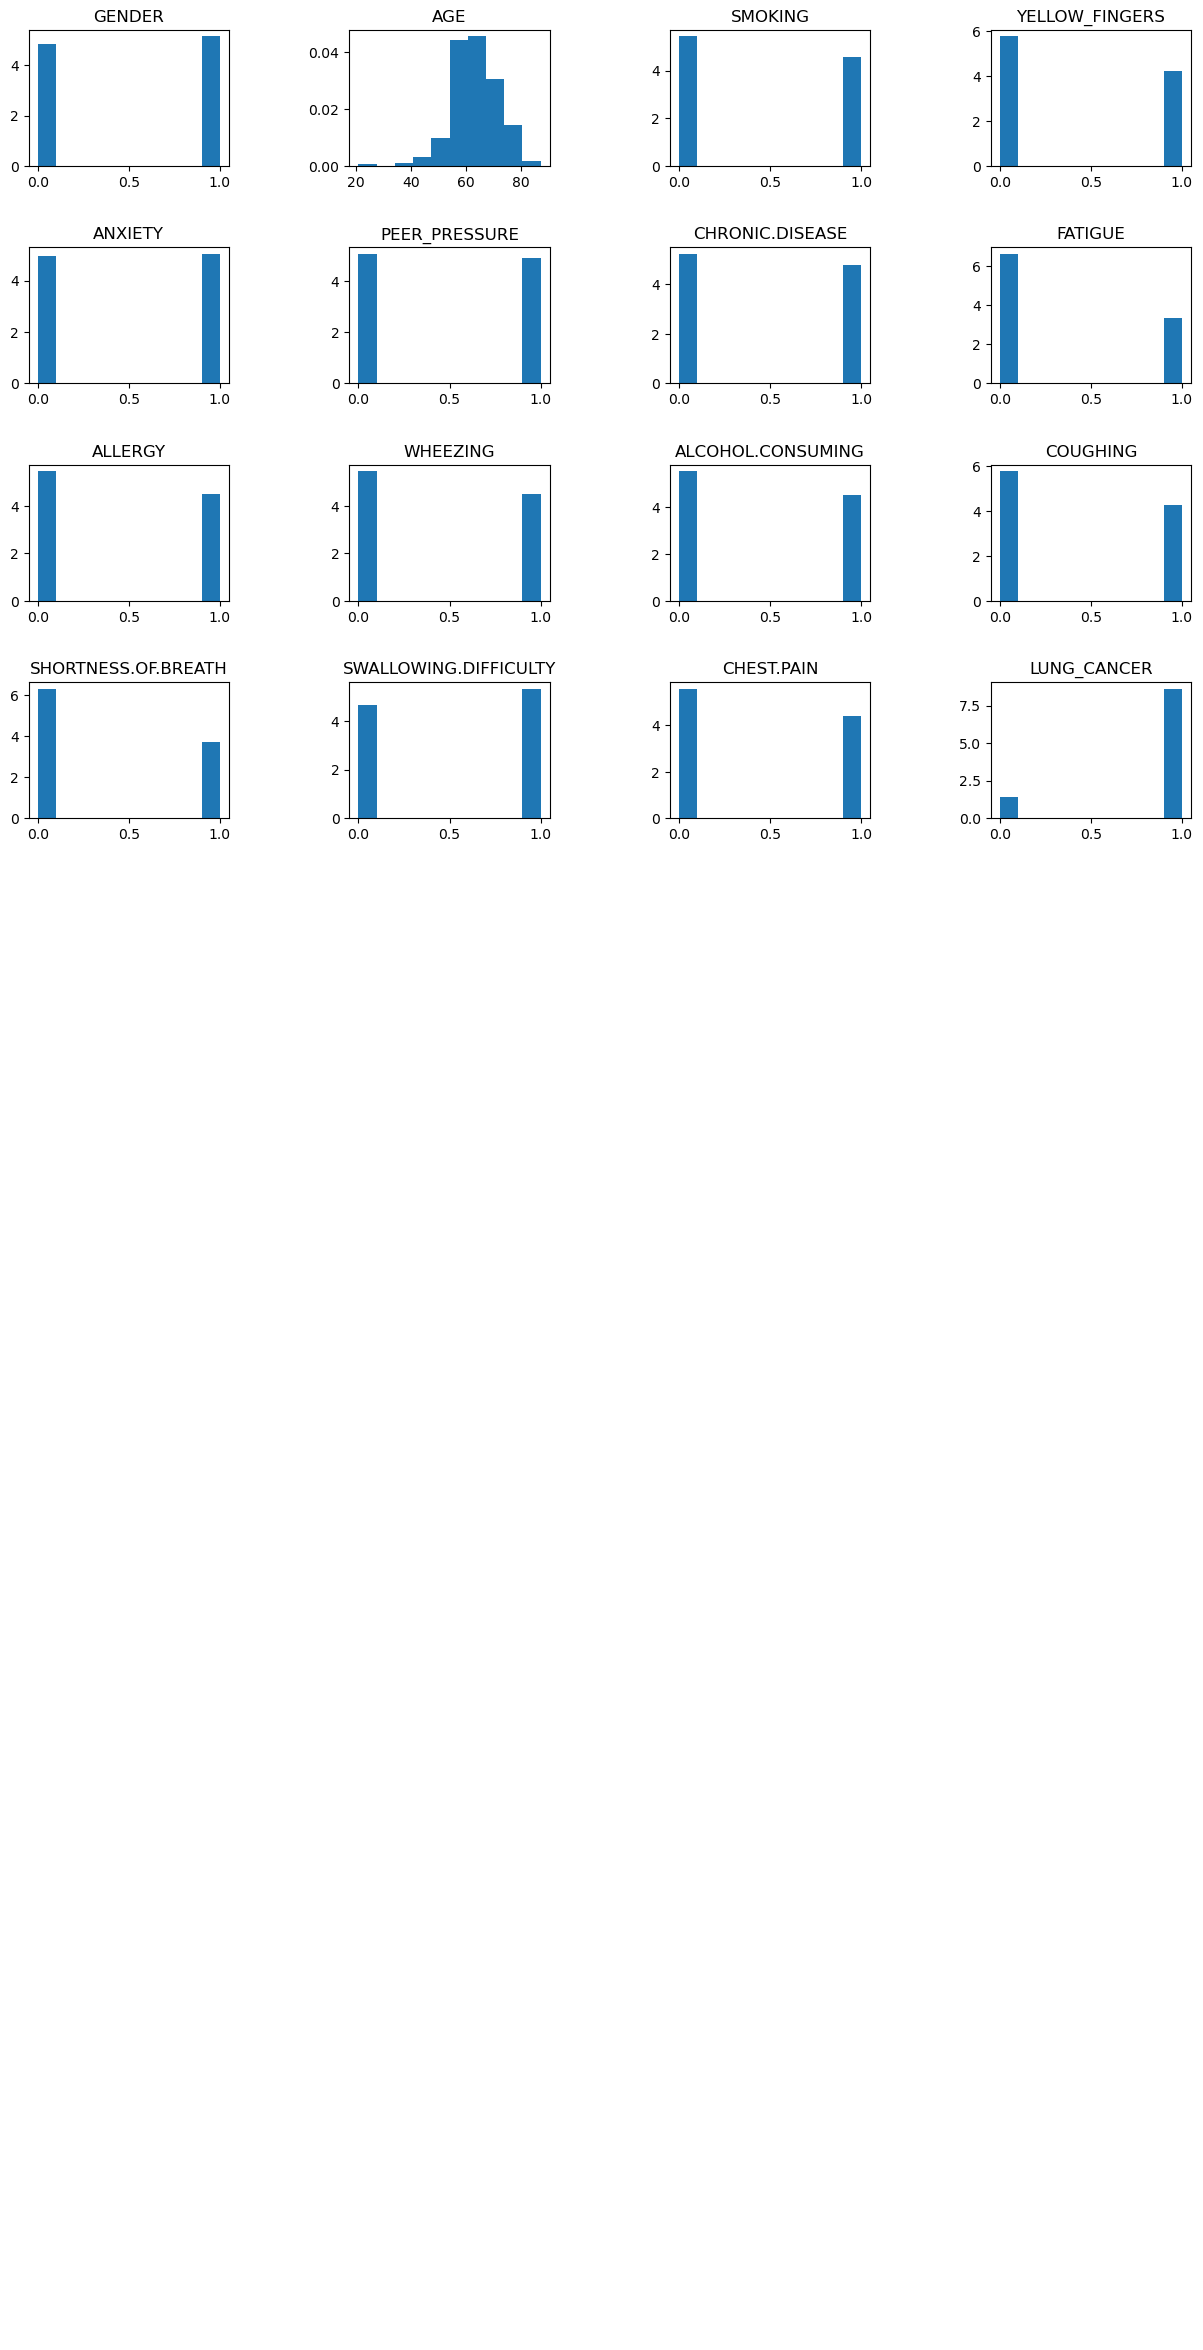

In [17]:
# Create the figure and subplots
fig, axs = plt.subplots(11, 4, figsize=(15, 30))

# Flatten the axs array to make it easier to iterate through
axs = axs.flatten()

# Loop through each feature and plot a histogram in a separate subplot
for i, col in enumerate(df_copy.columns):
    axs[i].hist(df_copy[col], density = True, bins=10)
    axs[i].set_title(col)

# Hide any unused subplots
for i in range(len(df_copy.columns), 11 * 4):
    axs[i].axis('off')

# Add a main title and adjust the spacing between subplots
#plt.suptitle('Histograms for Multiple Features')
plt.subplots_adjust(hspace=0.6, wspace=0.6)
#fig.suptitle("Histogram for the features", fontsize = 30)

# Show the plot
plt.show()

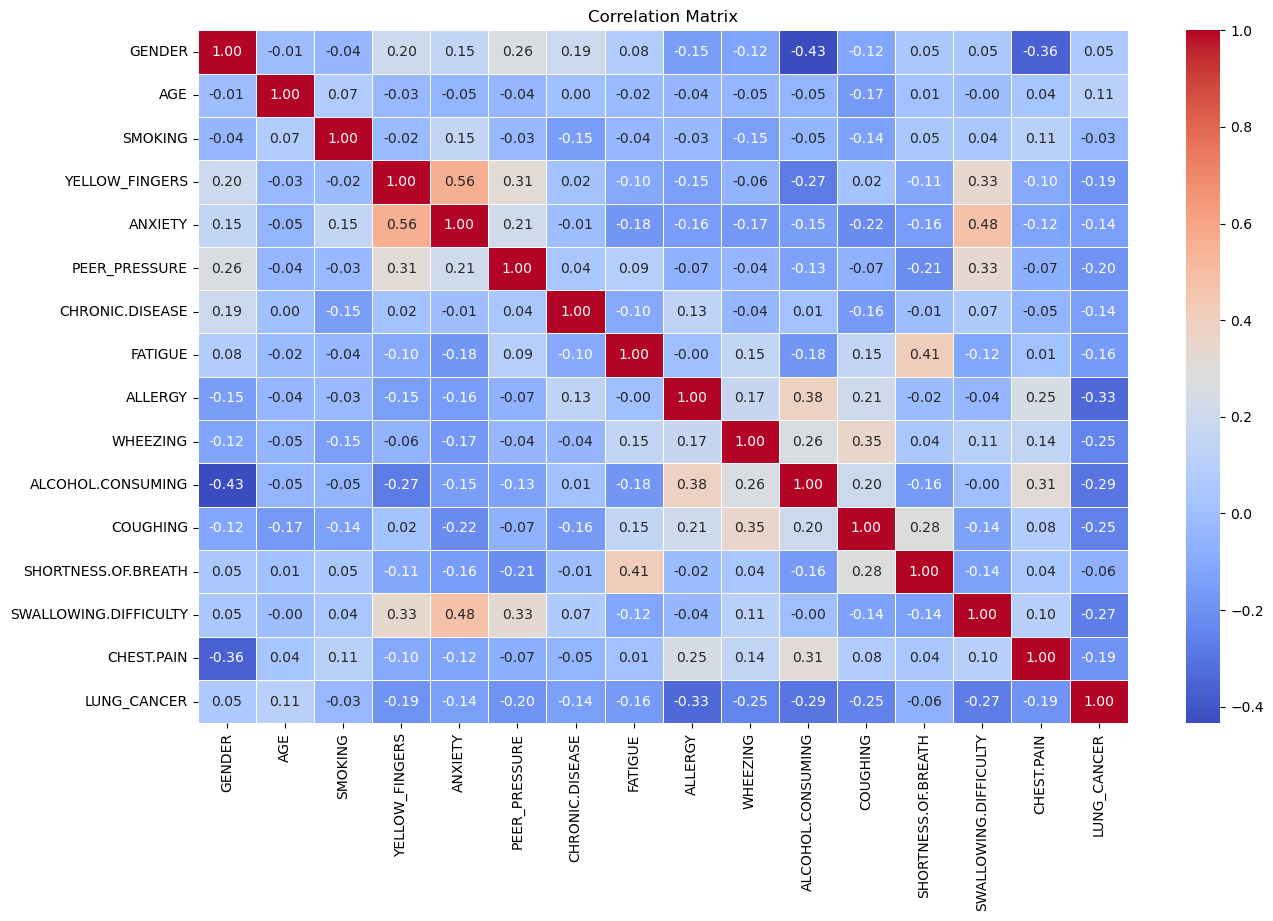

In [18]:
# Create the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 9))

# Plot the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title
plt.title('Correlation Matrix')

# Show plot
plt.show()


From the heatmap we don't  have highly correlated features

In [19]:
# Calculate the correlation matrix
corr_matrix = df_copy.corr().unstack().sort_values().drop_duplicates()
# Display the correlation matrix
print(corr_matrix)

GENDER               ALCOHOL.CONSUMING       -0.434264
CHEST.PAIN           GENDER                  -0.361547
LUNG_CANCER          ALLERGY                 -0.333552
ALCOHOL.CONSUMING    LUNG_CANCER             -0.294422
YELLOW_FINGERS       ALCOHOL.CONSUMING       -0.273643
                                                ...   
ALCOHOL.CONSUMING    ALLERGY                  0.378125
SHORTNESS.OF.BREATH  FATIGUE                  0.407027
ANXIETY              SWALLOWING.DIFFICULTY    0.478820
YELLOW_FINGERS       ANXIETY                  0.558344
CHRONIC.DISEASE      CHRONIC.DISEASE          1.000000
Length: 121, dtype: float64


# Splitting data into Training and Testing samples

In [20]:
X = df_copy.drop(["LUNG_CANCER"], axis=1) #independent
y = df_copy.LUNG_CANCER #dependent

In [21]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=101)

In [22]:
# Quick sanity check with the shapes of Training and testing datasets
print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

X_train -  (193, 15)
y_train -  (193,)
X_test -  (83, 15)
y_test -  (83,)


# models used
We will train five types of classifiers and decide which classifier will be more effective in detecting Lung Cancer condition.

We will use:
**Classification Models**

1. Random Forest
2. Adaptive Boosting( AdaBoost)
3. Gradient Boost
4. XGBoost
5. CatBoost

# Model Building
We are aware that our dataset is highly imbalanced, however, we check the performance of imbalance dataset first and later we implement some techniques to balance the dataset and again check the performance of balanced dataset. Finally, we will compare each regression models performance.

In [23]:
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
X_test

array([[-0.99483201,  0.42711845, -0.90595514, ..., -0.77995726,
        -1.10380741, -0.91547542],
       [ 1.00519484, -0.63730731, -0.90595514, ..., -0.77995726,
         0.90595514, -0.91547542],
       [-0.99483201, -1.70173307,  1.10380741, ...,  1.28212153,
         0.90595514,  1.09232862],
       ...,
       [-0.99483201, -0.51903778,  1.10380741, ..., -0.77995726,
        -1.10380741,  1.09232862],
       [ 1.00519484,  0.42711845,  1.10380741, ..., -0.77995726,
         0.90595514, -0.91547542],
       [ 1.00519484,  1.8463528 , -0.90595514, ..., -0.77995726,
        -1.10380741, -0.91547542]])

In [25]:
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 150],
        "learning_rate": [0.01, 0.1, 1.0],
    },
    "Gradient Boost": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 4, 5],
    },
    "XGBoost": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 4, 5],
        "gamma": [0, 0.1, 0.2],
    },
    "CatBoost": {
        "iterations": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "depth": [4, 6, 8],
    },
}


In [26]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)


In [27]:
Store_models = [
    ("Random Forest", RandomForestClassifier(random_state=123)),
    ("AdaBoost", AdaBoostClassifier(random_state=123)),
    ("Gradient Boost", GradientBoostingClassifier(random_state=123)),
    ("XGBoost", XGBClassifier(random_state=123)),
    ("CatBoost", CatBoostClassifier(random_state=123, silent=True)),
]


In [40]:
#pip install scikit-learn==1.3.2


Note: you may need to restart the kernel to use updated packages.


In [28]:
# Initialize an empty list to store results
tuned_results_list = []

for clf_name, clf in Store_models:
    print(f"Tuning hyperparameters for {clf_name}...")

    # Get the hyperparameter grid for the current model
    param_grid = param_grids[clf_name]

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_grid,
        n_iter=20,  # Number of different combinations to try
        cv=cv_strategy,
        scoring='accuracy',  # Metric to optimize for
        n_jobs=-1,  # Use all available processors
        verbose=1,
        random_state=123
    )

    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)

    # Get the best estimator
    best_model = random_search.best_estimator_

    # Make predictions with the best model
    predictions = best_model.predict(X_test)
    ypred_prob = best_model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    score = accuracy_score(y_test, predictions)
    rocAuc_score = roc_auc_score(y_test, ypred_prob)
    mcc = matthews_corrcoef(y_test, predictions)
    bal_acc = balanced_accuracy_score(y_test, predictions)
    kappa = cohen_kappa_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    # Store the results
    results_dict = {
        "Model": clf_name,
        "Best Params": random_search.best_params_,  # Store best params
        "Accuracy Score": score,
        'Roc_Auc_score': rocAuc_score,
        "MCC": mcc,
        "Balanced_Acc": bal_acc,
        "Cohen_Kappa": kappa,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

    # Append the dictionary to the list
    tuned_results_list.append(results_dict)

# Convert the list of dictionaries to a DataFrame
Tuned_model_results = pd.DataFrame(tuned_results_list)

# Sort by MCC or any other metric of interest
Tuned_model_results.sort_values(by="MCC", ascending=False)


Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


Tuning hyperparameters for AdaBoost...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Tuning hyperparameters for Gradient Boost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning hyperparameters for XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning hyperparameters for CatBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


Model                                        Best Params  \
1        AdaBoost        {'n_estimators': 100, 'learning_rate': 0.1}   
3         XGBoost  {'n_estimators': 300, 'max_depth': 5, 'learnin...   
0   Random Forest  {'n_estimators': 200, 'min_samples_split': 5, ...   
4        CatBoost  {'learning_rate': 0.2, 'iterations': 100, 'dep...   
2  Gradient Boost  {'n_estimators': 100, 'max_depth': 4, 'learnin...   

   Accuracy Score  Roc_Auc_score       MCC  Balanced_Acc  Cohen_Kappa  \
1        0.915663       0.925505  0.594765      0.758838     0.585296   
3        0.879518       0.917929  0.515930      0.776515     0.513482   
0        0.891566       0.952020  0.474362      0.706439     0.466809   
4        0.855422       0.934343  0.371212      0.685606     0.371212   
2        0.855422       0.876263  0.320816      0.647096     0.318741   

   Precision    Recall  F1 Score  
1   0.933333  0.972222  0.952381  
3   0.942857  0.916667  0.929577  
0   0.920000  0.958333  0.938776  
4   0.916667  0.916667  0.916667  
2   0.905405  0.930556  0.917808

In [29]:
# Drop the "Best Params" column from the final DataFrame
Tuned_model_results.drop(columns=["Best Params"], inplace=True)

# Sort by MCC or any other metric of interest
Tuned_model_results.sort_values(by="MCC", ascending=False)


Model  Accuracy Score  Roc_Auc_score       MCC  Balanced_Acc  \
1        AdaBoost        0.915663       0.925505  0.594765      0.758838   
3         XGBoost        0.879518       0.917929  0.515930      0.776515   
0   Random Forest        0.891566       0.952020  0.474362      0.706439   
4        CatBoost        0.855422       0.934343  0.371212      0.685606   
2  Gradient Boost        0.855422       0.876263  0.320816      0.647096   

   Cohen_Kappa  Precision    Recall  F1 Score  
1     0.585296   0.933333  0.972222  0.952381  
3     0.513482   0.942857  0.916667  0.929577  
0     0.466809   0.920000  0.958333  0.938776  
4     0.371212   0.916667  0.916667  0.916667  
2     0.318741   0.905405  0.930556  0.917808

#Confusion Matrix

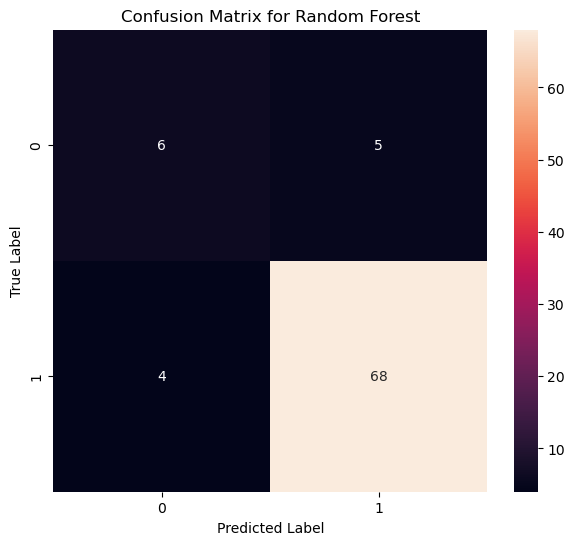

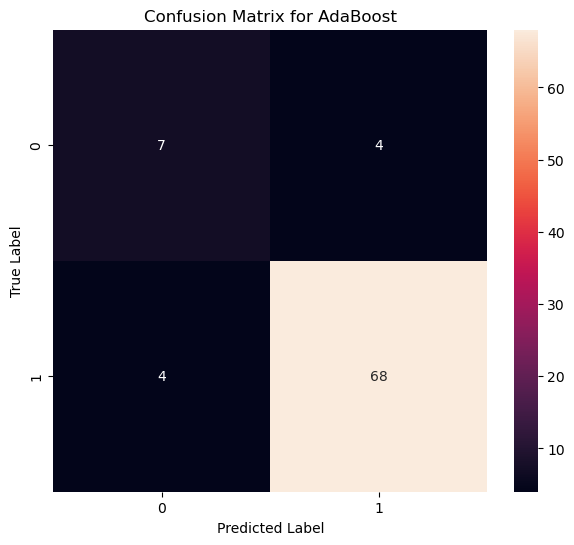

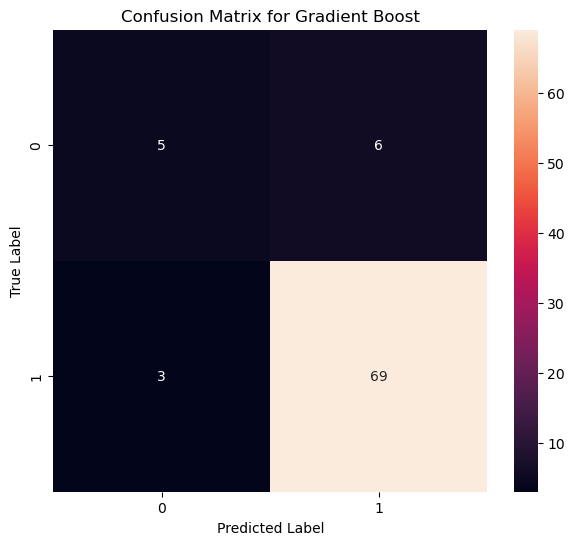

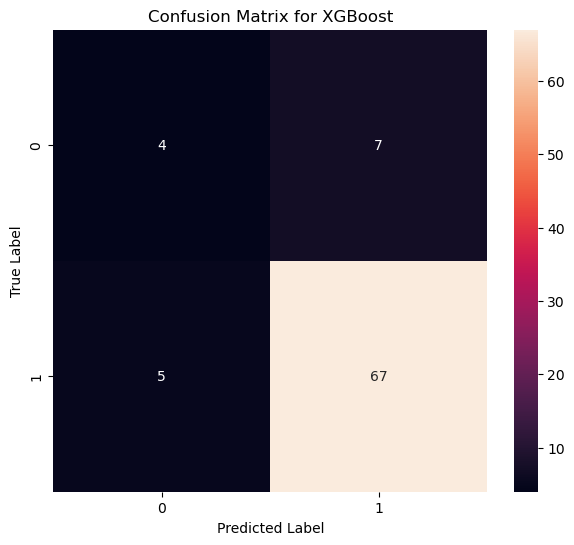

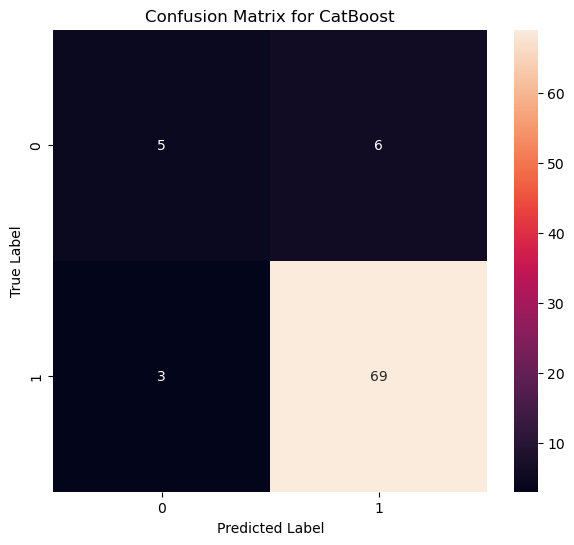

In [31]:
for model_name, model in Store_models:
    # Fit the model with your training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, predictions)

    # Plot the confusion matrix using seaborn's heatmap
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


In [32]:
y_test_series = y_test.squeeze()  # Convert DataFrame to Series
# Get the value counts of the Series
value_counts = y_test_series.value_counts()
print(value_counts)


LUNG_CANCER
1    72
0    11
Name: count, dtype: int64


#ROC Curve

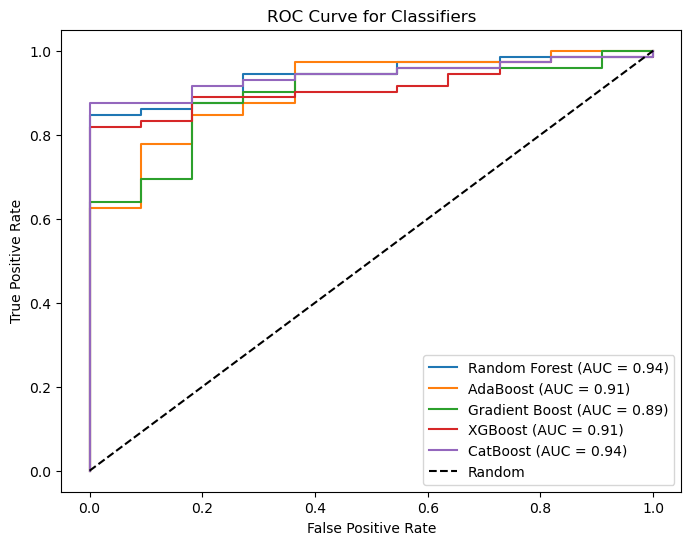

In [33]:
# Plot ROC curves for each classifier
plt.figure(figsize=(8, 6))

for clf_name, clf in Store_models:
    clf.fit(X_train, y_train)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classifiers')
plt.legend(loc='lower right')
plt.show()


# Class Imbalance

As found in EDA, the response variable Lung_cancer have unequal data.


To tackle the imbalance, we will be focuing on



## Random Oversampling
Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models.



# Oversampling

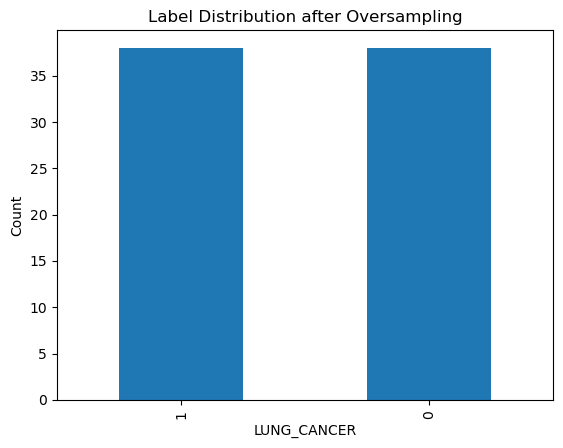

In [34]:
# over sampling of the dataset to get a balanced dataset
class_0 = df_copy[df_copy['LUNG_CANCER'] == 0]
class_1 = df_copy[df_copy['LUNG_CANCER'] == 1]

# over sampling of the minority class 1
class_1_over = class_1.sample(len(class_0), replace=True)

# Creating a new dataframe with over sampled class 1 df and class 0 df
df_new = pd.concat([class_1_over, class_0], axis=0)

# plotting the new label distribution
df_new['LUNG_CANCER'].value_counts().plot(kind='bar', title='Label Distribution after Oversampling')
plt.ylabel('Count')
plt.show()

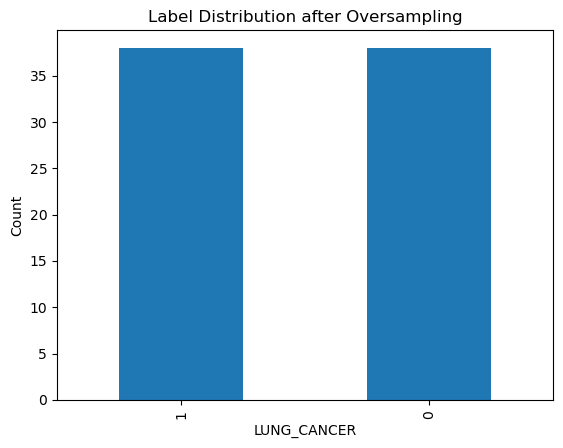

  0%|          | 0/5 [00:00<?, ?it/s]

Tuning hyperparameters for Random Forest using RandomizedSearchCV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 20%|██        | 1/5 [00:05<00:21,  5.41s/it]

Tuning hyperparameters for AdaBoost using RandomizedSearchCV...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


 40%|████      | 2/5 [00:07<00:10,  3.47s/it]

Tuning hyperparameters for Gradient Boost using RandomizedSearchCV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 60%|██████    | 3/5 [00:09<00:05,  2.96s/it]

Tuning hyperparameters for XGBoost using RandomizedSearchCV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 80%|████████  | 4/5 [00:10<00:02,  2.17s/it]

Tuning hyperparameters for CatBoost using RandomizedSearchCV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


100%|██████████| 5/5 [00:27<00:00,  5.44s/it]

            Model  Accuracy Score  Roc_Auc_score       MCC  Balanced_Acc  \
0   Random Forest        0.782609       0.928571  0.633279      0.843750   
1        AdaBoost        0.652174       0.834821  0.312527      0.669643   
2  Gradient Boost        0.739130       0.839286  0.501688      0.772321   
3         XGBoost        0.869565       0.937500  0.754155      0.906250   
4        CatBoost        0.826087       0.901786  0.690849      0.875000   

   Cohen_Kappa  Precision  Recall  
0     0.572491   1.000000  0.6875  
1     0.292308   0.833333  0.6250  
2     0.469231   0.916667  0.6875  
3     0.725100   1.000000  0.8125  
4     0.646154   1.000000  0.7500  


In [35]:


# over sampling of the dataset to get a balanced dataset
class_0 = df_copy[df_copy['LUNG_CANCER'] == 0]
class_1 = df_copy[df_copy['LUNG_CANCER'] == 1]

# over sampling of the minority class 1
class_1_over = class_1.sample(len(class_0), replace=True)

# Creating a new dataframe with over sampled class 1 df and class 0 df
df_new = pd.concat([class_1_over, class_0], axis=0)

# plotting the new label distribution
df_new['LUNG_CANCER'].value_counts().plot(kind='bar', title='Label Distribution after Oversampling')
plt.ylabel('Count')
plt.show()

X = df_new.drop('LUNG_CANCER', axis=1)  # features
y = df_new[['LUNG_CANCER']]  # labels

# splitting the features and labels into train and test with test size = 20% and train size = 80%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

# Define the models
Store_models_over = [
    ("Random Forest", RandomForestClassifier(random_state=123)),
    ("AdaBoost", AdaBoostClassifier(random_state=123)),
    ("Gradient Boost", GradientBoostingClassifier(random_state=123)),
    ("XGBoost", XGBClassifier(random_state=123)),
    ("CatBoost", CatBoostClassifier(random_state=123, silent=True)),
]

# Define hyperparameter grids
param_grids_over = {
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 150],
        "learning_rate": [0.01, 0.1, 1.0],
    },
    "Gradient Boost": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 4, 5],
    },
    "XGBoost": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 4, 5],
        "gamma": [0, 0.1, 0.2],
    },
    "CatBoost": {
        "iterations": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "depth": [4, 6, 8],
    },
}

# Initialize an empty list to store results
results_list_over = []

for clf_name, clf in tqdm(Store_models_over):
    print(f"Tuning hyperparameters for {clf_name} using RandomizedSearchCV...")

    # Get the hyperparameter grid for the current model
    param_grid = param_grids_over[clf_name]

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_grid,
        n_iter=10,  # Number of random combinations to try (adjust based on time)
        cv=5,  # Cross-validation
        scoring='accuracy',  # Metric to optimize for
        n_jobs=-1,  # Use all available processors
        verbose=1,
        random_state=123
    )

    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train.values.ravel())

    # Get the best estimator
    best_model = random_search.best_estimator_

    # Make predictions with the best model
    predictions = best_model.predict(X_test)
    ypred_prob = best_model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    score = accuracy_score(y_test, predictions)
    rocAuc_score = roc_auc_score(y_test, ypred_prob)
    mcc = matthews_corrcoef(y_test, predictions)
    bal_acc = balanced_accuracy_score(y_test, predictions)
    kappa = cohen_kappa_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    # Store results in a dictionary
    results_dict = {
        "Model": clf_name,
        "Accuracy Score": score,
        'Roc_Auc_score': rocAuc_score,
        "MCC": mcc,
        "Balanced_Acc": bal_acc,
        "Cohen_Kappa": kappa,
        "Precision": precision,
        "Recall": recall
    }

    # Append the dictionary to the list
    results_list_over.append(results_dict)

# Convert the list of dictionaries to a DataFrame
Store_model_results_over = pd.DataFrame(results_list_over)

# Sort by Precision or any other metric
Store_model_results_over.sort_values(by="Precision", ascending=False)

# Display the results
print(Store_model_results_over)


In [36]:
Store_model_results_over

Model  Accuracy Score  Roc_Auc_score       MCC  Balanced_Acc  \
0   Random Forest        0.782609       0.928571  0.633279      0.843750   
1        AdaBoost        0.652174       0.834821  0.312527      0.669643   
2  Gradient Boost        0.739130       0.839286  0.501688      0.772321   
3         XGBoost        0.869565       0.937500  0.754155      0.906250   
4        CatBoost        0.826087       0.901786  0.690849      0.875000   

   Cohen_Kappa  Precision  Recall  
0     0.572491   1.000000  0.6875  
1     0.292308   0.833333  0.6250  
2     0.469231   0.916667  0.6875  
3     0.725100   1.000000  0.8125  
4     0.646154   1.000000  0.7500

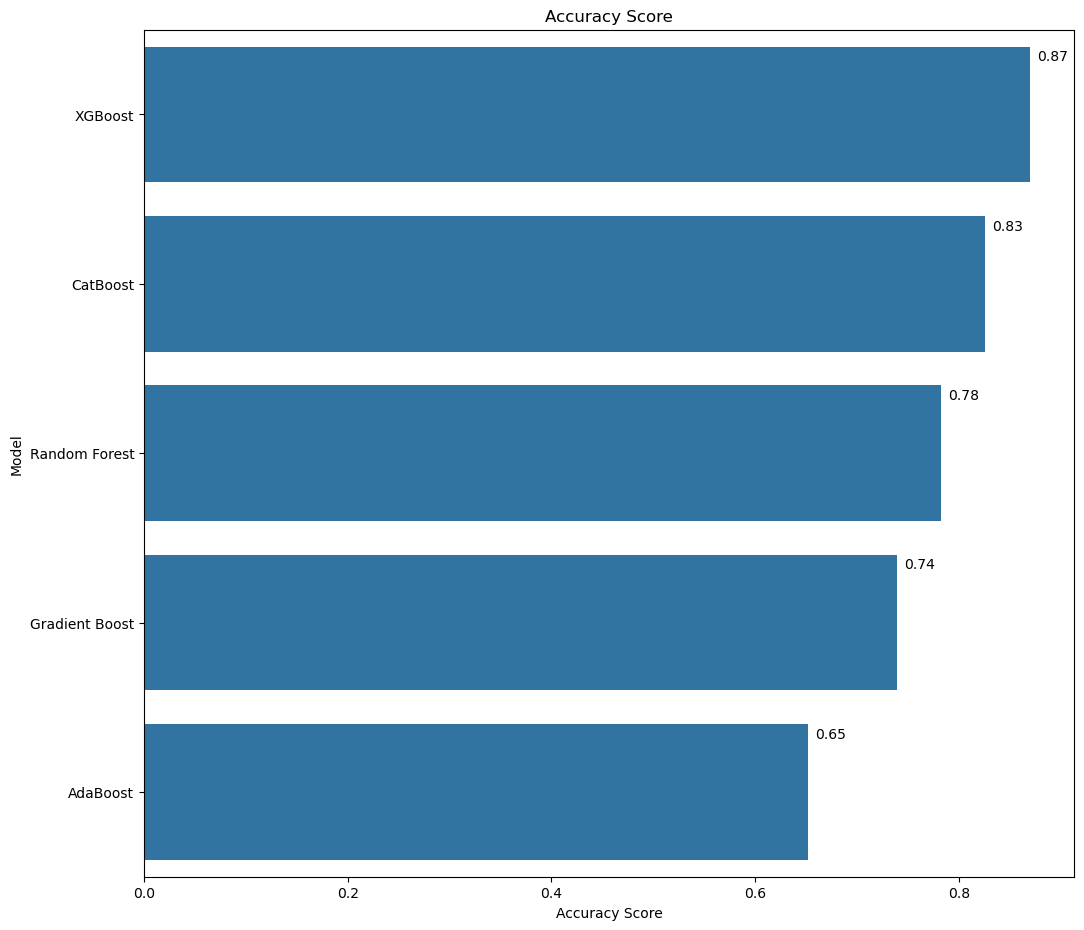

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the accuracy table
Accuracy_table = Store_model_results_over[["Model", "Accuracy Score"]].sort_values(by="Accuracy Score", ascending=False)

# Create the barplot
fig, ax = plt.subplots(figsize=(12, 11))
sns.barplot(y='Model', x='Accuracy Score', data=Accuracy_table, ax=ax).set(title="Accuracy Score")

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}',
                ((p.get_x() + p.get_width()), p.get_y()),
                xytext=(5, -10),
                textcoords='offset points')

plt.show()

**Confusion Matrix**

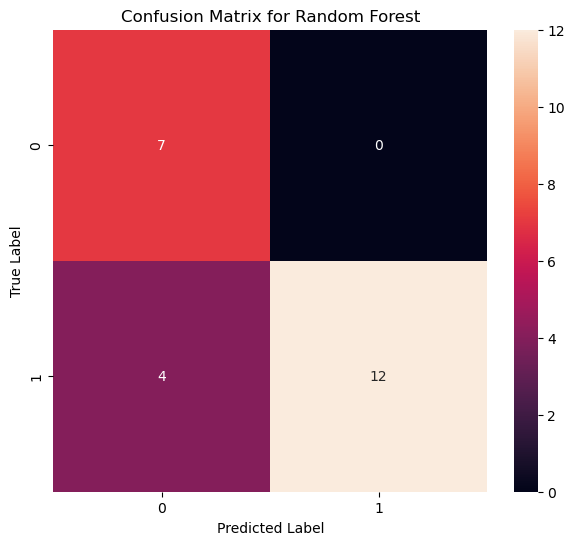

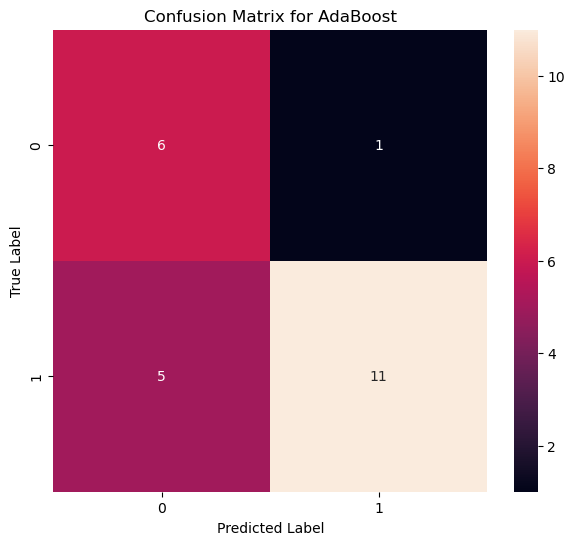

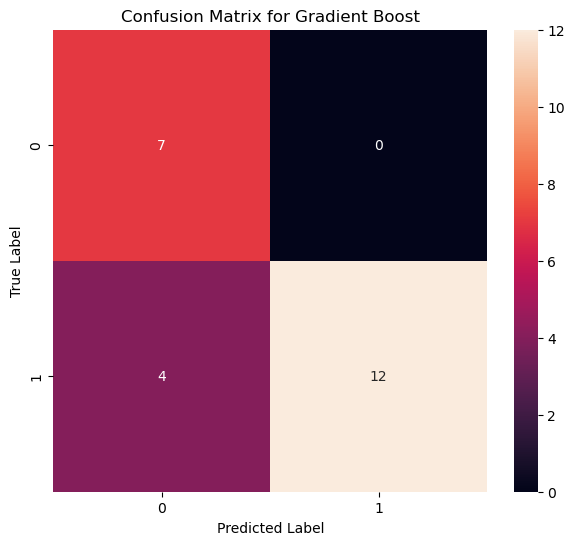

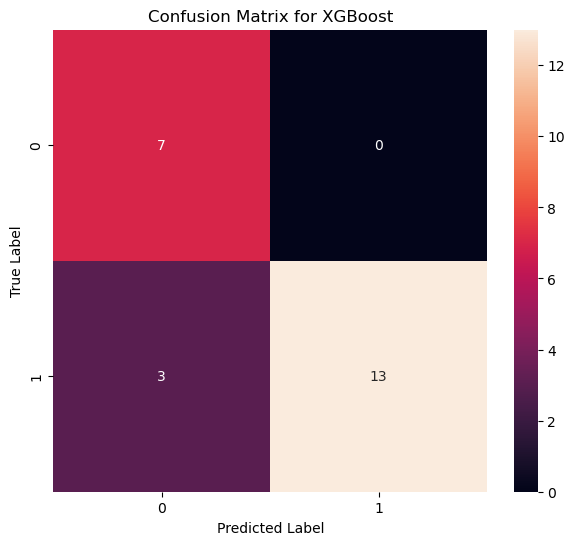

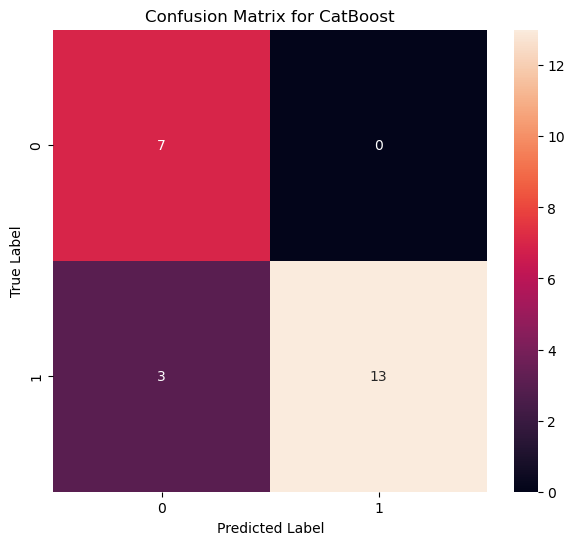

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for model_name, model in Store_models_over:
    # Fit the model with your training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, predictions)

    # Plot the confusion matrix using seaborn's heatmap
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


In [39]:
y_test_series = y_test.squeeze()  # Convert DataFrame to Series
# Get the value counts of the Series
value_counts = y_test_series.value_counts()
print(value_counts)


LUNG_CANCER
1    16
0     7
Name: count, dtype: int64


**ROC Curve**

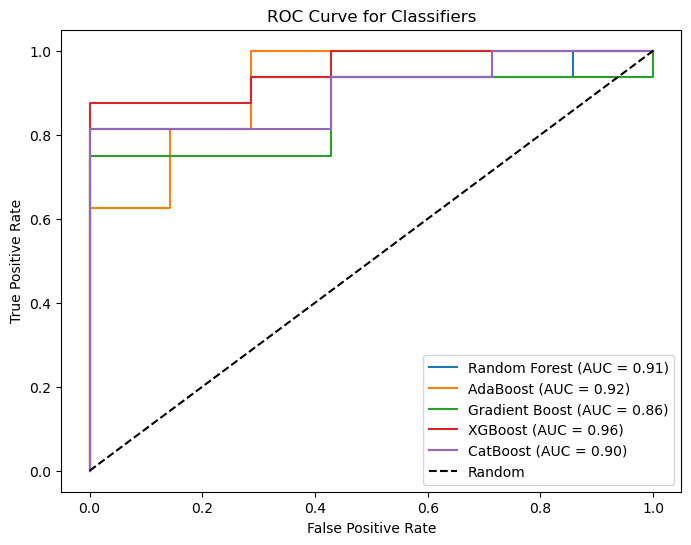

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot ROC curves for each classifier
plt.figure(figsize=(8, 6))

for clf_name, clf in Store_models_over:
    clf.fit(X_train, y_train)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classifiers')
plt.legend(loc='lower right')
plt.show()

# Feature Importance of the Top  Models using the MCC evaluation metrics

**Random Forest Classifier**

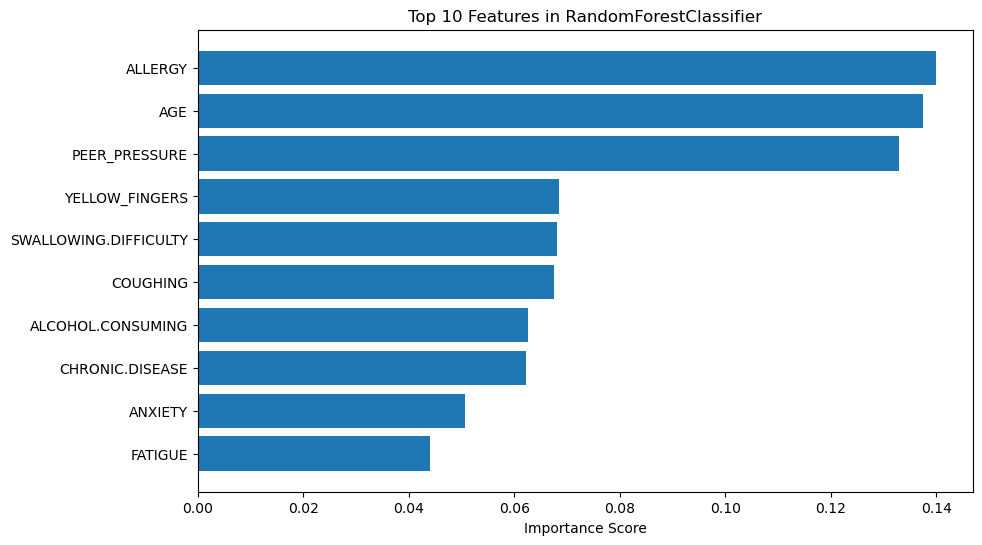

In [41]:
# Initialize RandomForestClassifier
random_forest = RandomForestClassifier(random_state=123)

# Train the model
random_forest.fit(X_train, y_train)

# Get feature importances from the trained model
importances = random_forest.feature_importances_

# Get the indices of the top 10 features with the highest importance scores
indices = np.argsort(importances)[-10:]

# Plot the top 10 features with their importance scores in a bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Importance Score')
plt.title('Top 10 Features in RandomForestClassifier')
plt.show()


#CatBoost Classifier

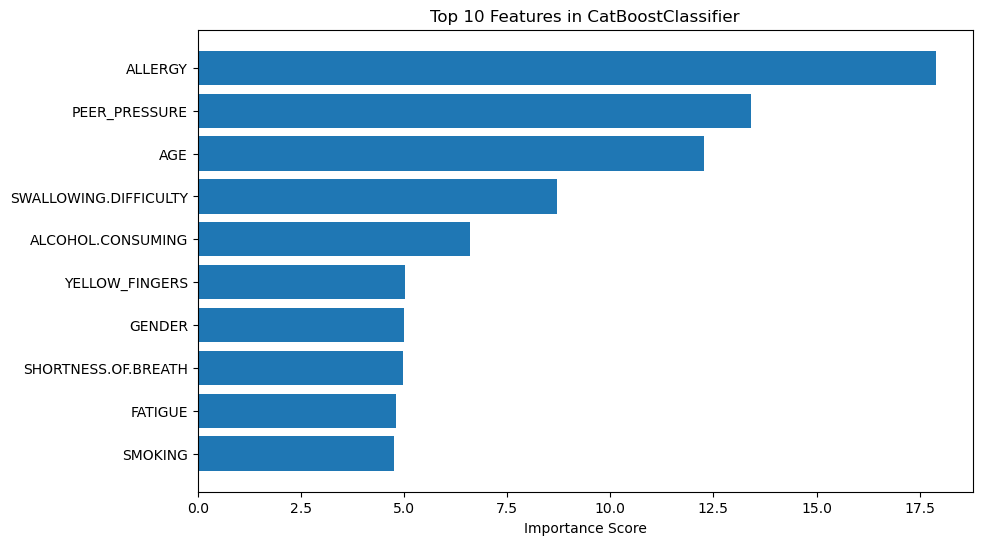

In [42]:
# Initialize CatBoostClassifier
catboost = CatBoostClassifier(random_state=123, silent=True)

# Train the model
catboost.fit(X_train, y_train)

# Get feature importances from the trained model
importances = catboost.get_feature_importance()

# Get the indices of the top 10 features with the highest importance scores
indices = np.argsort(importances)[-10:]

# Plot the top 10 features with their importance scores in a bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Importance Score')
plt.title('Top 10 Features in CatBoostClassifier')
plt.show()


# Plotting the Accuracy Scores

In [43]:
Accuracy_table = Store_model_results_over[["Model","Accuracy Score"]].sort_values(by = "Accuracy Score", ascending = False)
Accuracy_table

Model  Accuracy Score
3         XGBoost        0.869565
4        CatBoost        0.826087
0   Random Forest        0.782609
2  Gradient Boost        0.739130
1        AdaBoost        0.652174

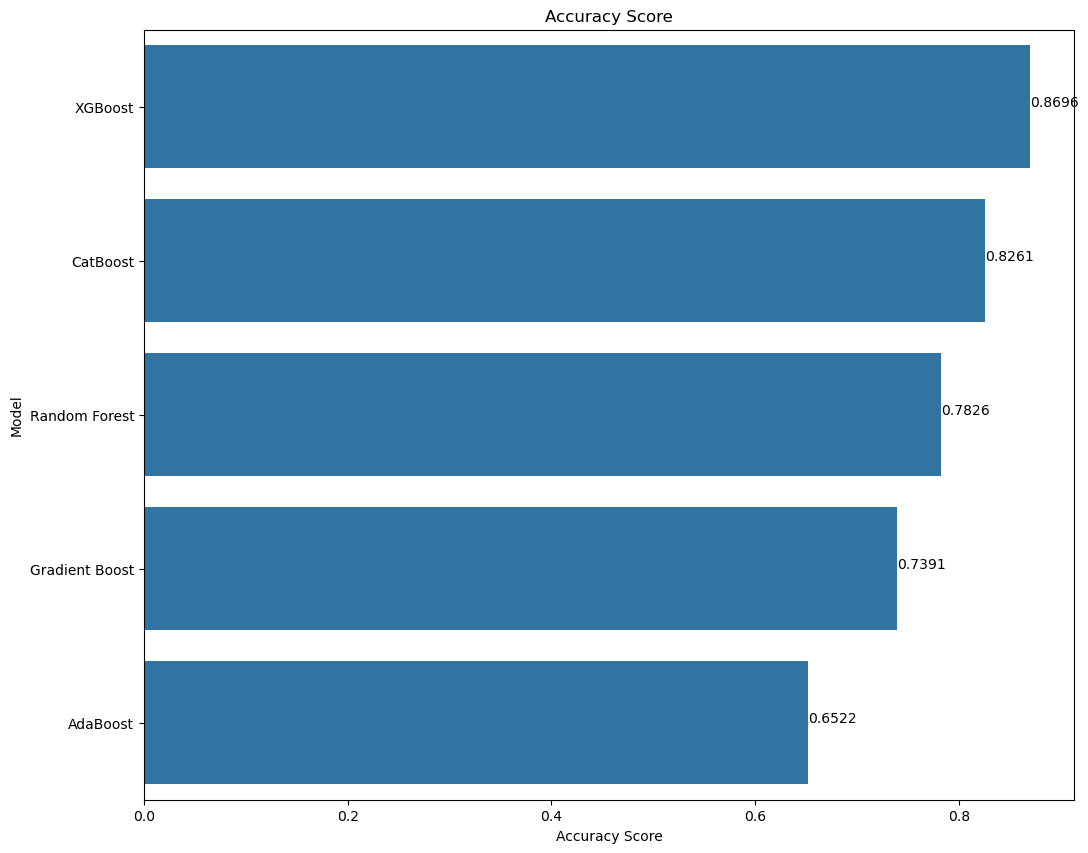

In [44]:
fig, ax = plt.subplots(figsize=(12, 10))

# drawing the plot
sns.barplot(y='Model', x='Accuracy Score', data=Accuracy_table, ax=ax).set(title="Accuracy Score")

# Add labels to the bars
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.5 * i.get_height(), f'{i.get_width():.4f}', fontsize=10, color='black')

plt.show()


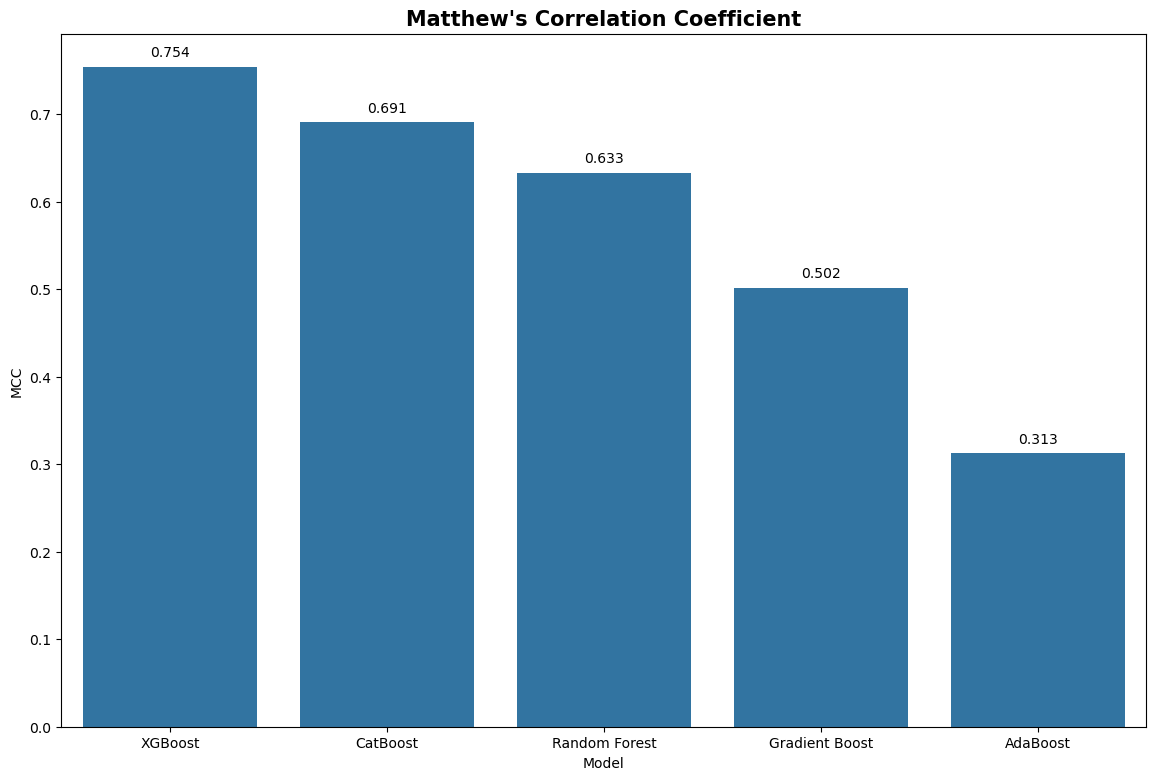

In [45]:
MCC_table = Store_model_results_over[["Model", "MCC"]].sort_values(by="MCC", ascending=False)
fig, ax = plt.subplots(figsize=(14, 9))

# drawing the plot
sns.barplot(x='Model', y='MCC', data=MCC_table, ax=ax)
plt.title("Matthew's Correlation Coefficient", fontweight='bold', fontsize=15)

# Add labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

plt.show()


# LIME

**Random Forest explainer**

In [47]:

instance_to_explain = X_test.iloc[0]

# Define your feature names with labels
feature_names_with_labels = list(X_train.columns)
feature_names_with_labels.append("LUNG_CANCER")

# Create a LIME explainer for tabular data with feature names including labels
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="classification", feature_names=feature_names_with_labels, class_names=['No Lung', 'LUNG_CANCER'])

# Explain the model's prediction for the chosen instance
explanation = explainer.explain_instance(instance_to_explain.values, random_forest.predict_proba, num_features=10)

# Display the explanation
explanation.show_in_notebook()


**CatBoost Explainer**

In [49]:

instance_to_explain = X_test.iloc[0]

# Define your feature names with labels
feature_names_with_labels = list(X_train.columns)
feature_names_with_labels.append("LUNG_CANCER")

# Create a LIME explainer for tabular data with feature names including labels
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="classification", feature_names=feature_names_with_labels, class_names=['No Lung', 'LUNG_CANCER'])

# Explain the model's prediction for the chosen instance
explanation = explainer.explain_instance(instance_to_explain.values, catboost.predict_proba, num_features=10)

# Display the explanation
explanation.show_in_notebook()


# **Permutation Feature Importance**

**CatBoost PFI**


Permutation Feature Importances:
WHEEZING: 0.0000
CHEST.PAIN: 0.0000
GENDER: 0.0096
AGE: 0.0100
COUGHING: 0.0113
ANXIETY: 0.0178
SMOKING: 0.0191
CHRONIC.DISEASE: 0.0222
SHORTNESS.OF.BREATH: 0.0239
FATIGUE: 0.0243
SWALLOWING.DIFFICULTY: 0.0343
ALCOHOL.CONSUMING: 0.0391
YELLOW_FINGERS: 0.0422
PEER_PRESSURE: 0.0609
ALLERGY: 0.0978


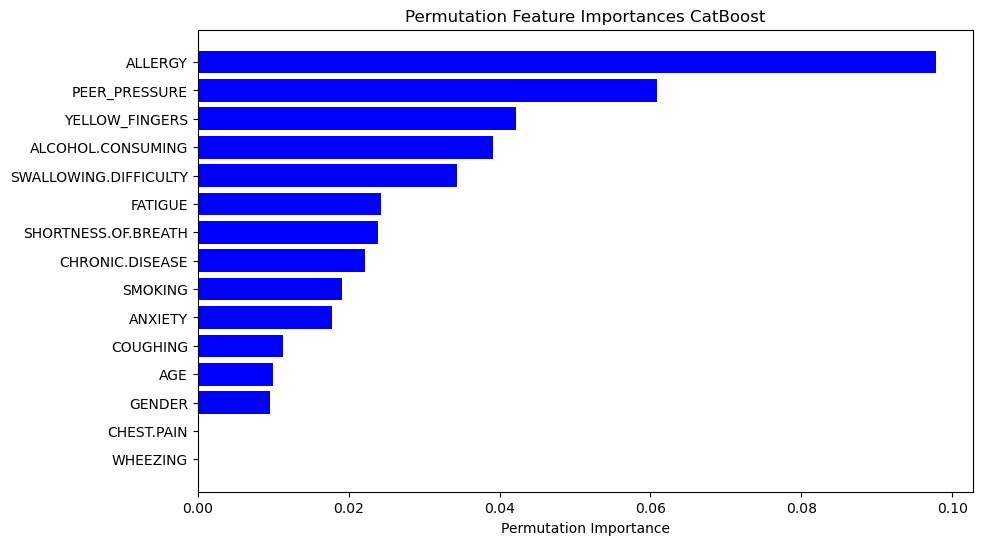

In [50]:
clf = CatBoostClassifier(random_state=70)

# Train the model
clf.fit(X_train, y_train, verbose=False)
#clf.fit(X_train_resampled, y_train_resampled, verbose=False)



# Evaluate the model's accuracy on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy of the model:", accuracy)

# Function to calculate permutation feature importance
def permutation_importance(model, X, y, metric, num_iterations=100):
    baseline_score = metric(y, model.predict(X))
    importances = {}
    for col in X.columns:
        importance_scores = []
        for _ in range(num_iterations):
            X_permuted = X.copy()
            X_permuted[col] = np.random.permutation(X_permuted[col])
            permuted_score = metric(y, model.predict(X_permuted))
            #importance_scores.append(permuted_score - baseline_score)
            importance_scores.append(baseline_score - permuted_score)
        importances[col] = np.mean(importance_scores)
    return importances

# Calculate permutation feature importance
importances = permutation_importance(clf, X_test, y_test, accuracy_score)

# Sort feature importances
sorted_importances = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=False)}

# Print feature importances
print("\nPermutation Feature Importances:")
for feature, importance in sorted_importances.items():
    print(f"{feature}: {importance:.4f}")

# Plotting feature importances
plt.figure(figsize=(10, 6))

# Assigning colors based on values
colors = ['blue' if v >= 0 else 'red' for v in sorted_importances.values()]

plt.barh(range(len(sorted_importances)), list(sorted_importances.values()), color=colors, align='center')
plt.yticks(range(len(sorted_importances)), list(sorted_importances.keys()))
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importances CatBoost')
plt.show()


**Random Forest PFI**


Permutation Feature Importances:
CHEST.PAIN: -0.0300
FATIGUE: -0.0257
SMOKING: -0.0174
AGE: -0.0139
SWALLOWING.DIFFICULTY: -0.0083
COUGHING: -0.0030
GENDER: 0.0000
WHEEZING: 0.0000
ANXIETY: 0.0143
ALLERGY: 0.0183
YELLOW_FINGERS: 0.0187
CHRONIC.DISEASE: 0.0226
ALCOHOL.CONSUMING: 0.0235
SHORTNESS.OF.BREATH: 0.0278
PEER_PRESSURE: 0.0509


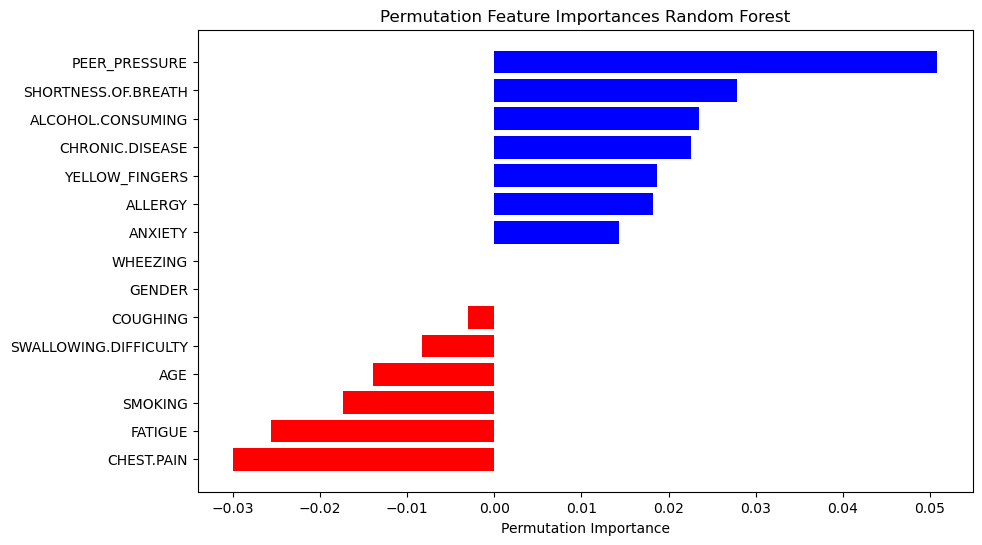

In [51]:
#Train a random forest classifier
clf = RandomForestClassifier(random_state=120)
# clf.fit(X_train, y_train)


# Train the model
#clf.fit(X_train, y_train)
clf.fit(X_train, y_train)



# Evaluate the model's accuracy on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy of the model:", accuracy)

# Function to calculate permutation feature importance
def permutation_importance(model, X, y, metric, num_iterations=100):
    baseline_score = metric(y, model.predict(X))
    importances = {}
    for col in X.columns:
        importance_scores = []
        for _ in range(num_iterations):
            X_permuted = X.copy()
            X_permuted[col] = np.random.permutation(X_permuted[col])
            permuted_score = metric(y, model.predict(X_permuted))
            #importance_scores.append(permuted_score - baseline_score)
            importance_scores.append(baseline_score - permuted_score)
        importances[col] = np.mean(importance_scores)
    return importances

# Calculate permutation feature importance
importances = permutation_importance(clf, X_test, y_test, accuracy_score)

# Sort feature importances
sorted_importances = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=False)}

# Print feature importances
print("\nPermutation Feature Importances:")
for feature, importance in sorted_importances.items():
    print(f"{feature}: {importance:.4f}")

# Plotting feature importances
plt.figure(figsize=(10, 6))

# Assigning colors based on values
colors = ['blue' if v >= 0 else 'red' for v in sorted_importances.values()]

plt.barh(range(len(sorted_importances)), list(sorted_importances.values()), color=colors, align='center')
plt.yticks(range(len(sorted_importances)), list(sorted_importances.keys()))
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importances Random Forest')
plt.show()


**SHAP**

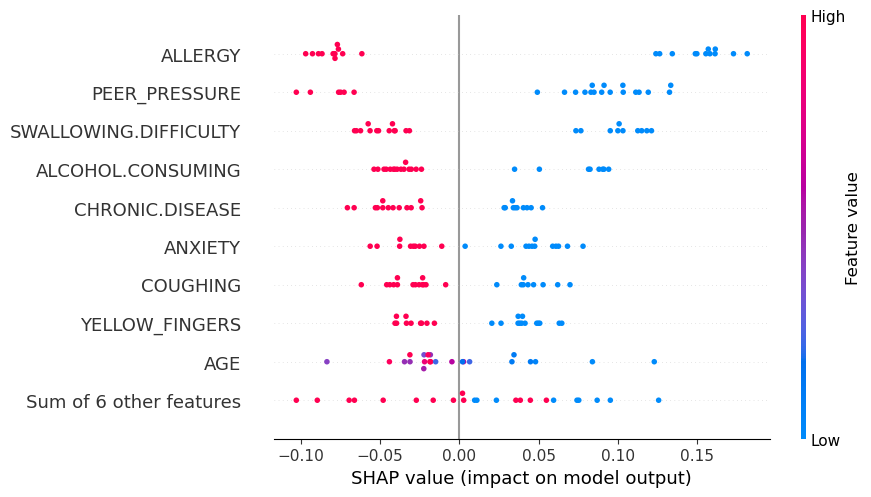

In [52]:
import shap
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Fit the Random Forest model
best_rf_model = RandomForestClassifier(random_state=123, n_estimators=300)
best_rf_model.fit(X_train, y_train)

# Create a SHAP explainer object
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Ensure we're working with the correct SHAP values for the positive class
if isinstance(shap_values, list):
    shap_values_positive = shap_values[1]  # For the positive class
else:
    shap_values_positive = shap_values

# If the shape is (n_samples, n_features, n_classes), flatten the third dimension
if shap_values_positive.ndim == 3:
    shap_values_positive = shap_values_positive[:, :, 1]  # Get SHAP values for the positive class

# Create an Explanation object
expl = shap.Explanation(values=shap_values_positive, data=X_test)

# Beeswarm plot using the Explanation object
shap.plots.beeswarm(expl)  # Pass the Explanation object



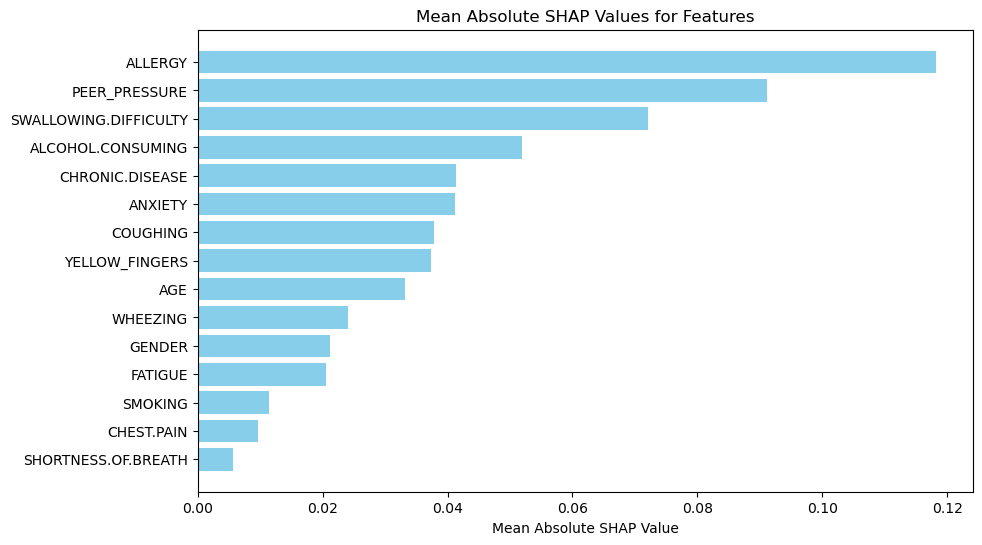

In [53]:



# Calculate absolute mean SHAP values
mean_shap_values = np.abs(shap_values_positive).mean(axis=0)

# Create a DataFrame for easier manipulation
feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Mean SHAP Value': mean_shap_values})

# Sort values by mean SHAP value
feature_importance = feature_importance.sort_values(by='Mean SHAP Value', ascending=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Mean SHAP Value'], color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Mean Absolute SHAP Values for Features')
plt.show()


# Ing.Oumar Moussa
# Data science researcher and passionate about AI applied to medicine
## LinkedIn : LinkedIn

## Github : https://github.com/Sanda-Oumar/

## Site web : My portfolio: https://oumarsanda.netlify.app

## Email : oumar.moussa@aims-cameroon.org